In [41]:
from data_loader import kline_api
from data_loader.generate_columns import generate, Data, Coinmarket
from datetime import datetime, timezone, timedelta
import time
import numpy as np
from scipy import stats
import datetime as dt
import matplotlib.pyplot as plt

In [5]:
def query_coin(coin, market):
    query = Coinmarket.select().where(Coinmarket.coin == coin, Coinmarket.market == market)
    try:
        return query[0]
    except IndexError:
        # Coin doesn't exist
        return False
    
def query_candles(coin, market, limit=None, start_date=None, end_date=None):
    from historical_data import Coinmarket, Data
    query = query_coin(coin, market)
    if(query != False):
        if(limit == None):
            if(isinstance(start_date, str)):
                start_date = convert(start_date)
            if(isinstance(end_date, str)):
                end_date = convert(end_date)
                # return Data.select().join(Coinmarket).where(Coinmarket.coin == coin, Coinmarket.market == market).order_by(Data.timestamp.asc())
            if(start_date == None and end_date != None):
                return Data.select().where(Data.timestamp <= end_date).join(Coinmarket).where(Coinmarket.coin == coin, Coinmarket.market == market).order_by(Data.timestamp.asc())
            elif(start_date != None and end_date == None):
                return Data.select().where(Data.timestamp >= start_date).join(Coinmarket).where(Coinmarket.coin == coin, Coinmarket.market == market).order_by(Data.timestamp.asc())
            elif(start_date != None and end_date != None):
                return Data.select().where(Data.timestamp >= start_date, Data.timestamp <= end_date).join(Coinmarket).where(Coinmarket.coin == coin, Coinmarket.market == market).order_by(Data.timestamp.asc())
            elif(start_date == None and end_date == None):
                return Data.select().join(Coinmarket).where(Coinmarket.coin == coin, Coinmarket.market == market).order_by(Data.timestamp.asc())
        else:
            return Data.select().join(Coinmarket).where(Coinmarket.coin == coin, Coinmarket.market == market).order_by(Data.timestamp.asc()).limit(limit)
    else:
        return False

In [13]:
import re

def convertCandles(coin, market, interval):

    def splitInterval(interval):
        res = re.findall('(\d+|[A-Za-z]+)', interval)
        return int(res[0]), res[1]

    interval_num, interval_type = splitInterval(interval)

    t = 1648706280000
    ts = datetime.fromtimestamp(int(t/1000))


    pretend_data = query_candles(coin, market)

    candle_array = []
    candle = {
      "high": [],
      "low": [],
      "close": 0,
      "BV": 0, # BTC Vol
      "V": 0, # Assets traded
    }

    current_count = {interval_type: 0}
    for value in range(1, len(pretend_data)):
        cur_time = datetime.fromtimestamp(int(pretend_data[value - 1].timestamp/1000))
        next_time = datetime.fromtimestamp(int(pretend_data[value].timestamp/1000))
        i = pretend_data[value-1]
        # PUT STUFF IN CANDLE DICT
        if("open" not in candle and "timestamp" not in candle):
            candle["open"] = float(i.open)
            candle['timestamp'] = i.timestamp
    #         print(f"New candle {datetime.fromtimestamp(int(pretend_data[value].timestamp/1000))}")

        candle['low'].append(float(i.low))
        candle['high'].append(float(i.high))
        candle['BV'] += float(i.shares)
        candle['V'] += float(i.btc_vol)
        if(interval_type == "h"):
            if(cur_time.hour != next_time.hour):
                current_count[interval_type] += 1

                if((cur_time.hour + 1) % interval_num == 0):
#                     print(cur_time, next_time)
                    candle['close'] = float(i.close)
                    candle_array.append({"timestamp": candle['timestamp'], "interval": "{}".format(interval), "open": candle['open'], 'high': max(candle['high']), "low": min(candle['low']), "close": candle['close'], "BV": round(candle['BV'], 8), "V": round(candle['V'], 8)})
                    # print()
                    candle = {
                      "high": [],
                      "low": [],
                      "close": 0,
                      "BV": 0,
                      "V": 0,
                    }
                    current_count[interval_type] = 0
        elif(interval_type == "m"):
            if(cur_time.minute != next_time):
                current_count[interval_type] += 1

                if((cur_time.minute + 1) % interval_num == 0):
#                     print(cur_time, next_time)
                    candle['close'] = float(i.close)
                    candle_array.append({"timestamp": candle['timestamp'], "interval": "{}".format(interval), "open": candle['open'], 'high': max(candle['high']), "low": min(candle['low']), "close": candle['close'], "BV": round(candle['BV'], 8), "V": round(candle['V'], 8)})
                    # print()
                    candle = {
                      "high": [],
                      "low": [],
                      "close": 0,
                      "BV": 0,
                      "V": 0,
                    }
                    current_count[interval_type] = 0



    # candle['close'] = float(pretend_data[-1].close)
    # if("open" not in candle and "timestamp" not in candle):
    #         candle["open"] = float(i.open)
    #         candle['timestamp'] = i.timestamp
    # candle_array.append({"timestamp": candle['timestamp'],"interval": "{}".format(interval), "open": candle['open'], 'high': max(candle['high']), "low": min(candle['low']), "close": candle['close'], "BV": round(candle['BV'], 8), "V": round(candle['V'], 8)})
    candle_array = candle_array[1:]
    return candle_array

In [14]:
m30 = convertCandles("XMR", "USDT", "30m")
h4 = convertCandles("XMR", "USDT", "4h")

In [15]:
print(len(h4))

2246


In [30]:
SEQ_LEN = 100

def to_sequences(data, seq_len):
    d = []

    for index in range(len(data) - seq_len):
        d.append(data[index: index + seq_len])

    return np.array(d)

def preprocess(data_raw, seq_len, train_split):

    data = to_sequences(data_raw, seq_len)

    num_train = int(train_split * data.shape[0])

    X_train = data[:num_train, :-1, :]
    y_train = data[:num_train, -1, :]

    X_test = data[num_train:, :-1, :]
    y_test = data[num_train:, -1, :]

    return X_train, y_train, X_test, y_test



In [22]:
print(len(X_train[0]))

99


In [24]:
import pandas as pd

prices = pd.DataFrame({'open': [i['open'] for i in h4],
                       'close': [i['close'] for i in h4],
                       'high': [i['high'] for i in h4],
                       'low': [i['low'] for i in h4]},
                       index=[datetime.fromtimestamp(int(i['timestamp']/1000)) for i in h4])

In [31]:
X_train, y_train, X_test, y_test =\
 preprocess(prices, SEQ_LEN, train_split = 0.95)

In [148]:
def calculate_slopes(data, length):
    LENGTH = 3
    slope_array = []
    intercept_array = []
    for i in range(LENGTH, len(h4)):
        slope, intercept, r, p, std_err = stats.linregress([int(i['timestamp']) for i in data[i-LENGTH:i]], [float(i['close']) for i in data[i-LENGTH:i]])
        slope_array.append(slope)
        intercept_array.append(intercept)
#         def myfunc(x):
#             return slope * x + intercept
        
#         mymodel = list(map(myfunc, [(i['timestamp']) for i in h4[i-LENGTH:i]]))
# #         print(mymodel)
#         plt.plot([datetime.fromtimestamp(int(i['timestamp']/1000)) for i in h4[i-LENGTH:i]], [float(i['close']) for i in h4[i-LENGTH:i]])
#         # plt.plot(prices.index, mymodel)
#         plt.plot([datetime.fromtimestamp(int(i['timestamp']/1000)) for i in h4[i-LENGTH:i]], mymodel)

#         plt.show()

    
#     prices = pd.DataFrame({
#                           'slope' : slope_array,
#                       'intercept': intercept_array},
#                        index=[datetime.fromtimestamp(int(i['timestamp']/1000)) for i in data[LENGTH:]])
    prices = pd.DataFrame({'open': [i['open'] for i in h4],
                           'close': [i['close'] for i in h4],
                           'high': [i['high'] for i in h4],
                           'low': [i['low'] for i in h4]},
                           index=[datetime.fromtimestamp(int(i['timestamp']/1000)) for i in h4])
    return prices

In [149]:
new_data = calculate_slopes(h4, 3)

In [151]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
slope = new_data.open.values.reshape(-1,1)
scaled_slope = scaler.fit_transform(slope)

In [152]:
SEQ_LEN = 100

def to_sequences(data, seq_len):
    d = []

    for index in range(len(data) - seq_len):
        d.append(data[index: index + seq_len])

    return np.array(d)

def preprocess(data_raw, seq_len, train_split):

    data = to_sequences(data_raw, seq_len)

    num_train = int(train_split * data.shape[0])

    X_train = data[:num_train, :-1, :]
    y_train = data[:num_train, -1, :]

    X_test = data[num_train:, :-1, :]
    y_test = data[num_train:, -1, :]

    return X_train, y_train, X_test, y_test


In [153]:
X_train, y_train, X_test, y_test =\
 preprocess(scaled_slope, SEQ_LEN, train_split = 0.95)

In [154]:
y_train

array([[0.03895283],
       [0.04009106],
       [0.04439105],
       ...,
       [0.78495848],
       [0.78082712],
       [0.7794781 ]])

In [155]:
import keras
import tensorflow
from keras.layers import Bidirectional, CuDNNLSTM, Dropout, Dense, Activation, LSTM
DROPOUT = 0.2
WINDOW_SIZE = SEQ_LEN - 1

model = keras.Sequential()

model.add(Bidirectional(
  LSTM(WINDOW_SIZE, return_sequences=True),
  input_shape=(WINDOW_SIZE, X_train.shape[-1])
))
model.add(Dropout(rate=DROPOUT))

model.add(Bidirectional(
  LSTM((WINDOW_SIZE * 2), return_sequences=True)
))
model.add(Dropout(rate=DROPOUT))

model.add(Bidirectional(
  LSTM(WINDOW_SIZE, return_sequences=False)
))

model.add(Dense(units=1))

model.add(Activation('linear'))

In [156]:
BATCH_SIZE = 64

model.compile(
    loss='mean_squared_error',
    optimizer='adam'
)

history = model.fit(
    X_train,
    y_train,
    epochs=10,
    batch_size=BATCH_SIZE,
    shuffle=True,
    validation_split=0.1
)

Epoch 1/10
29/29 [==============================] - 38s 1s/step - loss: 0.0088 - val_loss: 0.0125
Epoch 2/10
29/29 [==============================] - 37s 1s/step - loss: 0.0012 - val_loss: 0.0037
Epoch 3/10
29/29 [==============================] - 38s 1s/step - loss: 4.6636e-04 - val_loss: 0.0027
Epoch 4/10
29/29 [==============================] - 38s 1s/step - loss: 3.9336e-04 - val_loss: 0.0041
Epoch 5/10
29/29 [==============================] - 38s 1s/step - loss: 3.5910e-04 - val_loss: 0.0022
Epoch 6/10
29/29 [==============================] - 39s 1s/step - loss: 3.7296e-04 - val_loss: 0.0030
Epoch 7/10
29/29 [==============================] - 38s 1s/step - loss: 3.2309e-04 - val_loss: 0.0026
Epoch 8/10
29/29 [==============================] - 38s 1s/step - loss: 3.4897e-04 - val_loss: 0.0023
Epoch 9/10
29/29 [==============================] - 38s 1s/step - loss: 3.9093e-04 - val_loss: 0.0016
Epoch 10/10
29/29 [==============================] - 38s 1s/step - loss: 3.1547e-04 - val_

In [157]:
y_hat = model.predict(X_test)

In [158]:
y_test_inverse = scaler.inverse_transform(y_test)
y_hat_inverse = scaler.inverse_transform(y_hat)

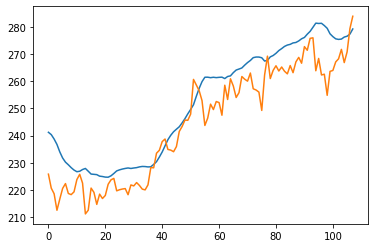

In [159]:
plt.plot([i[0] for i in y_hat_inverse])
plt.plot([i[0] for i in y_test_inverse])